In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier

/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Задача классификации тональности текста (коротких сообщений)

Intro:

Количествео классов, на которые делят тональность, обычно задается из спецификации разработываемой системы, по сути от целей решения данной задачи. Самый распространенный кейс (который показывают в туториалах и описывают в статьях) это бинарная классификация на положительный и отрицательный окрас тональности, на практике же 2 классов маловато для адекватной системы, поэтому чаще всего когда дело доходит до реальных задач - появляется еще нейтральный класс и задача уже превращается в мультиклассовую (положительный, отрицательный, нейтральный).

Решать мультиклассовую задачу можно двумя основными подходами: плосской классификацией и иерархической классификацией.

1. Плоская классификация - обучаем только один классификатор, который сразу же будет решать мультиклассовую задачу разделения объектов на 3 клсса (положительный, отрицательный, нейтральный)
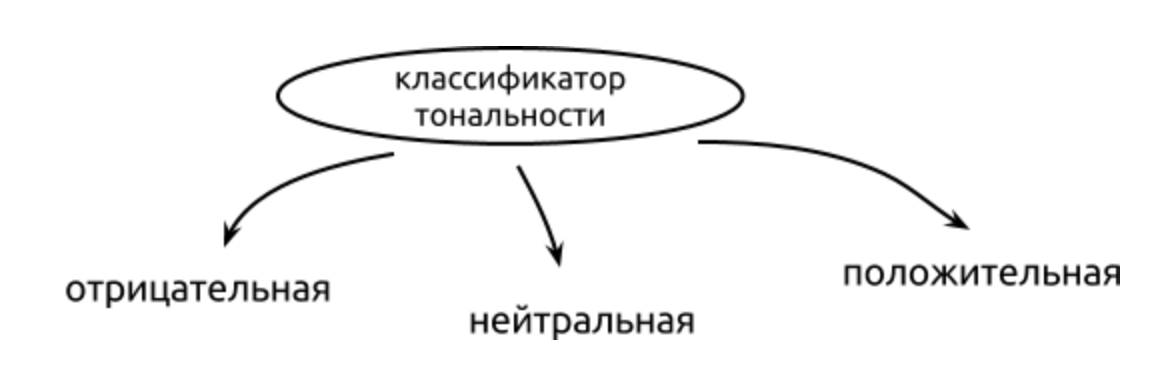
2. Иерархическая классификация - делим классы на группы и обучаем несколько классификаторов, каждый из которых решает задачу бинарной классификации. Наример если мы имеем не 2 и не 3 класса, а например 5 (сильно положительный, средне положительный, нейтральный, средне отрицательный, сильно отрицательный), то решить задачу одной моделькой, которая будет различать 5 классов очень проблематично будет, возможно конечно, но проблематично.
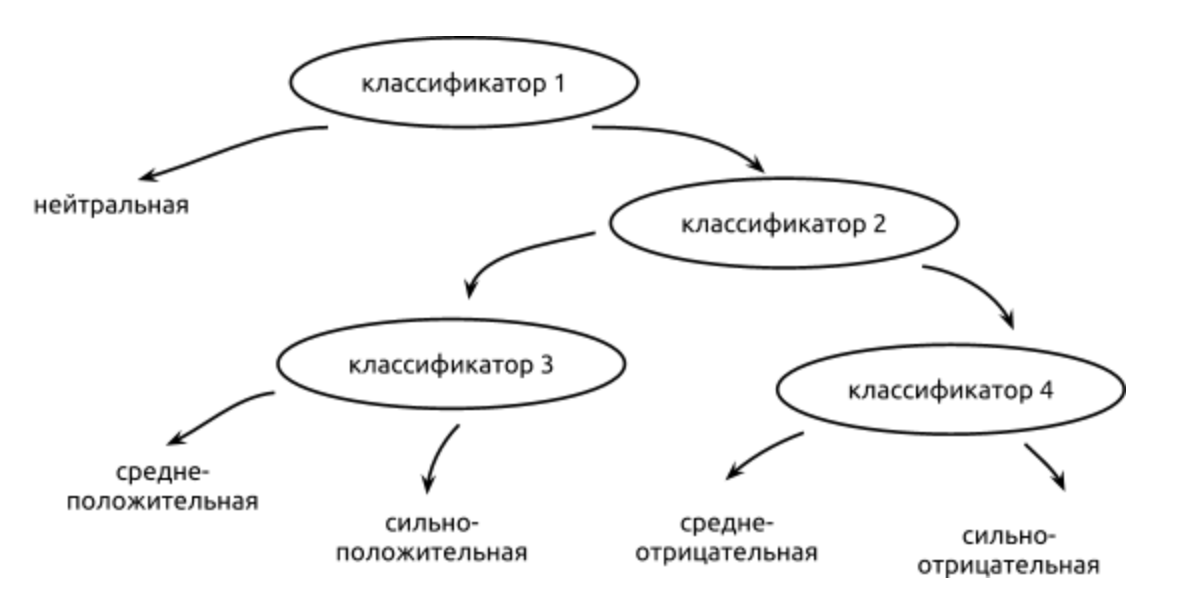

Лично я придерживаюсь второй стратегии и предпочитаю обучать несколкьо бинарных классификаторов, а не один мультиклассовый и даже для задачи с 3 классами мне такой подход нравится куда больше, но Вы можете решить для себя сами как удобнее именно Вам.

In [5]:
#загружаем первый набор данных, в котором есть сообщения, размеченные на 3 класса
#этот набор данных будем использовать для обучения "нетрального" классификатора, который 
#будет решать задачу бинарной классификации "neutral" или "not_neutral"

#0 - neutral,1 - positive,2 - negative
Client_Sms_v2_path = '/Users/m.zolotarev/Desktop/clientSMS_v2.csv'
Client_Sms_v2 = pd.read_csv(Client_Sms_v2_path,sep = ';',header = None)
Client_Sms_v2.columns = ['1']
Client_Sms_v2_Messages = Client_Sms_v2['1']

#текст сообщения и таргет находятся в одном поле, явно разделим текст сообщения и соответствующий ему трагет класса
MessageText = []
ClassTag = []
for mess in Client_Sms_v2_Messages:
    mess_tag = mess.split('\t')
    MessageText.append(mess_tag[0])
    ClassTag.append(mess_tag[1])
    
#заменим "positive" и "negative" классы на общий класса "not_neutral"
ClassTagClear = []
for tag in ClassTag:
    if tag == '0':
        ClassTagClear.append(0)
    else:
        ClassTagClear.append(1)
        
#сформируем необходимый нам генеральный набор данных для обучения "нейтрального" классификатора 
#0 - neural, 1 - not_neutral(positive+negative)
GeneralData_NeutralClassifier = {'message':MessageText,'class':ClassTagClear}
DataSet_NeutralClassifier = pd.DataFrame(data = GeneralData_NeutralClassifier)
DataSet_NeutralClassifier['message'] = DataSet_NeutralClassifier['message'].astype('str')
DataSet_NeutralClassifier['class'] = DataSet_NeutralClassifier['class'].astype('int')

In [6]:
#посмотрим первые 5 строк генерального набора данных для обучений "нейтрального" классификатора
DataSet_NeutralClassifier.head()

,message,class
0,У Вас есть один пропущенный вызов 09.08.2016 в...,0
1,"Кирилл дома, я позже позвоню",1
2,И что,1
3,Я пнрезвоню,1
4,Ты ток Андрюхе не говори про Руса что разбился...,1


In [8]:
#посмотрим последние 5 строк генерального набора данных для обучения "нейтрального" классификатора
DataSet_NeutralClassifier.tail()

,message,class
3895,Вас срочно просит позвонить абонент +79504357145,1
3896,"Нет, в ВК меня нет. Спасибо за заботу...",1
3897,"Еду уберешь в холодильник когда придёшь, с соб...",1
3898,это не сетевой маркетинг?,1
3899,Завтра,0


In [11]:
#для обучения второго классификатора, который будет решить задачу бинарной классификации "positive" или "not_positive"
#воспользуемся набором данных, в которм представленны все 3 класса, возьмем только "positive" и "nagative", после чего
#обогатим эти данными из наборов данных, в которых представлены только данные "positive" и "negative"

#0 - neutral,1 - positive,2 - negative
Client_Sms_v2_path = '/Users/m.zolotarev/Desktop/clientSMS_v2.csv'
Client_Sms_v2 = pd.read_csv(Client_Sms_v2_path,sep = ';',header = None)
Client_Sms_v2.columns = ['1']
Client_Sms_v2_Messages = Client_Sms_v2['1']

#текст сообщения и таргет класса находятся в одном поле, явно разделим текст сообщения и соответствующий ему трагет класса
MessageText_1 = []
ClassTag_1 = []
for mess in MessageText_1:
    mess_tag = mess.split('\t')
    MessageText_1.append(mess_tag[0])
    ClassTag_1.append(mess_tag[1])
    
Client_Sms_v2_data = {'message':MessageText_1,'class':ClassTag_1}
Client_Sms_v2 = pd.DataFrame(data = Client_Sms_v2_data)
Client_Sms_v2['message'] = Client_Sms_v2['message'].astype('str')
Client_Sms_v2['class'] = Client_Sms_v2['class'].astype('int')

#возьмем из мультиклассового набора данных только позитивные сообщения
MessageText_1 = Client_Sms_v2.loc[Client_Sms_v2['class'] == 1]
MessageText_1 = MessageText_1['message']
ClassTag_1 = np.ones(len(MessageText_1))
ClassTag_1 = ClassTag_1.astype('int')

#возьмем из мультиклассового набора данных только негативные сообщения
MessageText_2 = Client_Sms_v2.loc[Client_Sms_v2['class'] == 2]
MessageText_2 = MessageText_2['message']
ClassTag_2 = np.zeros(len(MessageText_2))
ClassTag_2 = ClassTag_2.astype('int')

#обогатительный набор данных для позитивных сообщений
Positive_path = '/Users/m.zolotarev/Desktop/positive.csv'
Positive = pd.read_csv(Positive_path,sep = ';',header = None)
Positive.columns = ['1','2','3','4','5','6','7','8','9','10','11','12']
MessageText_3 = Positive['4']
ClassTag_3 = np.ones(len(MessageText_3))
ClassTag_3 = ClassTag_3.astype('int')

#обогатительный набор данных для негативных сообщений
Negative_path = '/Users/m.zolotarev/Desktop/negative.csv'
Negative = pd.read_csv(Negative_path,sep = ';',header = None)
Negative.columns = ['1','2','3','4','5','6','7','8','9','10','11','12']
MessageText_4 = Negative['4']
ClassTag_4 = np.zeros(len(MessageText_4))
ClassTag_4 = ClassTag_4.astype('int')

#сформируем генеральный рабор данных для обучения "позитивного" классификатора ("positive" или "not_positive")
MessageText_PositiveClassifier = np.concatenate((MessageText_1,MessageText_2,MessageText_3,MessageText_4),axis = 0)
ClassTag_PositiveClassifier = np.concatenate((ClassTag_1,ClassTag_2,ClassTag_3,ClassTag_4),axis = 0)
GeneralData_PositiveClassifier = {'message':MessageText_PositiveClassifier,'class':ClassTag_PositiveClassifier}
DataSet_PositiveClassifier = pd.DataFrame(data = GeneralData_PositiveClassifier)
DataSet_PositiveClassifier['message'] = DataSet_PositiveClassifier['message'].astype('str')
DataSet_PositiveClassifier['class'] = DataSet_PositiveClassifier['class'].astype('int')

In [12]:
#посмотрим первые 5 строк генерального набора данных для обучений "позитивного" классификатора
DataSet_PositiveClassifier.head()

,message,class
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1


In [13]:
#посмотрим последние 5 строк генерального набора данных для обучения "позитивного" классификатора
DataSet_PositiveClassifier.tail()

,message,class
226829,Но не каждый хочет что то исправлять:( http://...,0
226830,скучаю так :-( только @taaannyaaa вправляет мо...,0
226831,"Вот и в школу, в говно это идти уже надо(",0
226832,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",0
226833,Такси везет меня на работу. Раздумываю приплат...,0


Приступим к обучению и тестированию "нейтрального" и "позитивного" классификаторов

In [14]:
#сформируем случайным образом обучающую и тестовую выборки в соотношении 80% на 20% для "нейтрального" классификатора
Messages_NeutralClassifier = DataSet_NeutralClassifier['message']
ClassTag_NeutralClassifier = DataSet_NeutralClassifier['class']
XTrain_Neutr,XTest_Neutr,YTrain_Neutr,YTest_Neutr = train_test_split(Messages_NeutralClassifier,
                                                                     ClassTag_NeutralClassifier,
                                                                     stratify = ClassTag_NeutralClassifier,
                                                                     test_size = 0.2,
                                                                     random_state = 40)

Раз мы решаем задачу классификации - не забываем проверять как обстоят дела с балансом классов в обучающей и тестовой выборках

In [15]:
#проверим баланс классов в тренировочных наборах данных
Neutral_Train = []
NotNeutral_Train = []
for i in YTrain_Neutr:
    if i == 0:
        Neutral_Train.append(i)
    else:
        NotNeutral_Train.append(i)
        
print('Number of training elements neutral class: ',len(Neutral_Train))
print('Number of training elements not neutral class: ',len(NotNeutral_Train))

Number of training elements neutral class:  1766
Number of training elements not neutral class:  1354


In [16]:
#проверим баланс классов в тестовых наборах данных
Neutral_Test = []
NotNeutral_Test = []
for i in YTest_Neutr:
    if i == 0:
        Neutral_Test.append(i)
    else:
        NotNeutral_Test.append(i)
        
print('Number of testing elements neutral class: ',len(Neutral_Test))
print('Number of testing elements not neutral class: ',len(NotNeutral_Test))

Number of testing elements neutral class:  442
Number of testing elements not neutral class:  338


In [18]:
#сформируем случайным образом обучающую и тестовую выборки в соотношении 80% на 20% для "позитивного" классификатора
Messages_PositiveClassifier = DataSet_PositiveClassifier['message']
ClassTag_PositiveClassifier = DataSet_PositiveClassifier['class']
XTrain_Pos,XTest_Pos,YTrain_Pos,YTest_Pos = train_test_split(Messages_PositiveClassifier,
                                                             ClassTag_PositiveClassifier,
                                                             stratify = ClassTag_PositiveClassifier,
                                                             test_size = 0.2,
                                                             random_state = 40)

In [19]:
Negative_Train = []
Positive_Train = []
for i in YTrain_Pos:
    if i == 0:
        Negative_Train.append(i)
    else:
        Positive_Train.append(i)
        
print('Number of training elements negative class: ',len(Negative_Train))
print('Number of training elements positive class: ',len(Positive_Train))

Number of training elements negative class:  89538
Number of training elements positive class:  91929


In [20]:
Negative_Test = []
Positive_Test = []
for i in YTest_Pos:
    if i == 0:
        Negative_Test.append(i)
    else:
        Positive_Test.append(i)
        
print('Number of testing elements negative class: ',len(Negative_Test))
print('Number of testing elements positive class: ',len(Positive_Test))

Number of testing elements negative class:  22385
Number of testing elements positive class:  22982


В задачах NLP как и в задачах прогнозирования временных рядов львиную долю успеха составляет процесс предварительной обработки данных, текст сам по себе очень сложная структура тем более для понимания машиной, текст может быть зашумлен всяким мусором, который не несет в себе никакой смысловой нагрузки (особенно это касается сообщений в чатах, где люди пишут вообще как попало).

Кроме того, что нужно очистить текст от мусора - нужно провети токенизацию текста (разделение на отдельные слова) для того, чтобы получить вектора этих слов с помощью одной из методик embedding.

1. Очистка текста от шума
2. Токенизация
3. Embedding

In [21]:
#очистим для начала текст от служемного символа переноса на новую строку
def CleanText(Corpus):
    corpus = [z.lower().replace('\n','').split() for z in Corpus]
    return corpus

In [22]:
#neutral classifier
XTrain_NC = CleanText(XTrain_Neutr)
XTest_NC = CleanText(XTest_Neutr)

In [23]:
#positive classifier 
XTrain_PC = CleanText(XTrain_Pos)
XTest_PC = CleanText(XTest_Pos)

In [24]:
#функция очистки от лишнего шумового мусора в тексте сообщений
def CleanTextFromGarbage(Corpus,Symbol):

    num = 0
    for mess in Corpus:
        for word in mess:
            word = str(word)
            if Symbol in word:
                index = mess.index(word)
                del mess[index]
                num=num+1
    print('num = ',num)
    return num

In [26]:
#очистим набор данных для "нейтрального" классификатора

#никнеймы, которые начинаются с символа '@'
NumTrain = None
NumTest = None
while NumTrain != 0:
    NumTrain = CleanTextFromGarbage(XTrain_NC,'@')
while NumTest != 0:
    NumTest = CleanTextFromGarbage(XTest_NC,'@')
    
#http
NumTrain = None
NumTest = None
while NumTrain != 0:
    NumTrain = CleanTextFromGarbage(XTrain_NC,'http')
while NumTest != 0:
    NumTest = CleanTextFromGarbage(XTest_NC,'http')
    
#хэштеги
NumTrain = None
NumTest = None
while NumTrain != 0:
    NumTrain = CleanTextFromGarbage(XTrain_NC,'#')
while NumTest != 0:
    NumTest = CleanTextFromGarbage(XTest_NC,'#')
    
#rt
NumTrain = None
NumTest = None
while NumTrain != 0:
    NumTrain = CleanTextFromGarbage(XTrain_NC,'rt')
while NumTest != 0:    
    NumTest = CleanTextFromGarbage(XTest_NC,'rt')
    
#номера телефонов
NumTrain = None
NumTest = None
while NumTrain != 0:
    NumTrain = CleanTextFromGarbage(XTrain_NC,'+7')
while NumTest != 0:
    NumTest = CleanTextFromGarbage(XTest_NC,'+7')

#адреса сайтов
NumTrain = None
NumTest = None
while NumTrain != 0:
    NumTrain = CleanTextFromGarbage(XTrain_NC,'.ru')
while NumTest != 0:
    NumTest = CleanTextFromGarbage(XTest_NC,'.ru')

num =  0
num =  0
num =  0
num =  0
num =  0
num =  0
num =  0
num =  0
num =  0
num =  0
num =  0
num =  0


In [28]:
#очистим набор данных для "позитивного" классификатора

#никнеймы, которые начинаются с символа '@'
NumTrain = None
NumTest = None
while NumTrain != 0:
    NumTrain = CleanTextFromGarbage(XTrain_PC,'@')
while NumTest != 0:
    NumTest = CleanTextFromGarbage(XTest_PC,'@')
    
#http
NumTrain = None
NumTest = None
while NumTrain != 0:
    NumTrain = CleanTextFromGarbage(XTrain_PC,'http')
while NumTest != 0:
    NumTest = CleanTextFromGarbage(XTest_PC,'http')
    
#хэштеги
NumTrain = None
NumTest = None
while NumTrain != 0:
    NumTrain = CleanTextFromGarbage(XTrain_PC,'#')
while NumTest != 0:
    NumTest = CleanTextFromGarbage(XTest_PC,'#')
    
#rt
NumTrain = None
NumTest = None
while NumTrain != 0:
    NumTrain = CleanTextFromGarbage(XTrain_PC,'rt')
while NumTest != 0:
    NumTest = CleanTextFromGarbage(XTest_PC,'rt')
    
#номера телефонов
NumTrain = None
NumTest = None
while NumTrain != 0:
    NumTrain = CleanTextFromGarbage(XTrain_PC,'+7')
while NumTest != 0:
    NumTest = CleanTextFromGarbage(XTest_PC,'+7')
    
#адреса сайтов
NumTrain = None
NumTest = None
while NumTrain != 0:
    NumTrain = CleanTextFromGarbage(XTrain_PC,'.ru')
while NumTest != 0:
    NumTest = CleanTextFromGarbage(XTrain_PC,'.ru')

num =  0
num =  0
num =  0
num =  0
num =  0
num =  0
num =  0
num =  0
num =  0
num =  0
num =  0
num =  0


После того как мы очистили наши наборы данных для обучения и тестирования классификаторов, перейдем к процессу преобразования текста в вектора, для этого воспользуемся инструментом word2vec из пакета gensim.

In [29]:
#функция для формирования векторов слов с помощью word2vec
def BuildWordVector(Text,Size,Word2Vec_Model):

    vec = np.zeros(Size).reshape((1,Size))
    count = 0.

    for word in Text:
        try:
            vec += Word2Vec_Model[word].reshape((1,Size))
            count += 1.
        except KeyError:
            continue
    
    if count != 0:
        vec /= count
    
    return vec

Как мы знаем, word2vec хороша в том случае если у нас много текста, воспользуемся этим свойством

In [30]:
XTrain = XTrain_NC + XTrain_PC #соединим тренировочные данные для обоих классификаторов в один набор данных
XTest = XTest_NC + XTest_PC #соединяем тестовые данные для обих классификаторов в один набор данных

In [31]:
NDim = 100 #длина вектора (гипер-параметр, вообще зависит от объема имеющихся для обучения данных)
Imdb_w2v = Word2Vec(size = NDim,min_count = 10)

#изначально модель word2vec должна точно так же обучиться на тренировочных данных и ничего не знать о тестовых
#поэтому словарь мы создами только из тренировочного набора данных
Imdb_w2v.build_vocab(XTrain)

In [32]:
#обучаем модель word2vec
Imdb_w2v.train(XTrain,total_examples = Imdb_w2v.corpus_count,epochs = Imdb_w2v.epochs)

(5789373, 10115155)

In [33]:
#преобразуем тренировочный набор данных для "нейтрального" классификатора в вектора (embedding)
TrainVecs_NC = np.concatenate([BuildWordVector(i,NDim,Imdb_w2v) for i in XTrain_NC])

In [34]:
#преобразуем тренировочный набор данных для "позитивного" классификатора в вектора (embedding)
TrainVecs_PC = np.concatenate([BuildWordVector(i,NDim,Imdb_w2v) for i in XTrain_PC])

После того как мы получили вектороное представление слов из тренировочного набора данных, можно обучить word2vec заново для получения векторого представления слов из тестового набора данных, там образом мы избежали ситуации утечки данных из обучающей выборки в тестовую и наоборот.

In [35]:
Imdb_w2v.train(XTest,total_examples = Imdb_w2v.corpus_count,epochs = Imdb_w2v.epochs)

(1438671, 2537855)

In [36]:
#embedding testing messages to vectors for neutral classifier
TestVecs_NC = np.concatenate([BuildWordVector(i,NDim,Imdb_w2v) for i in XTest_NC])

In [37]:
#embedding testing messages to vectors for positive classifier
TestVecs_PC = np.concatenate([BuildWordVector(i,NDim,Imdb_w2v) for i in XTest_PC])

После того как мы получили векторонное представление наших выборок, можно приступать к обучению и тестированию "нейтрального" и "позитивного" классификаторов. В качестве алгоритма, на которых будут основаны модели классификации возьмем старый-добрый, наш любимый случайный лес.

"Нейтральный" классификатор:

In [38]:
#провалидируем "нейтральный" классификатор с помощью кроссвалидации на 5 фолдах
Forest_NC = RandomForestClassifier(n_estimators = 100,max_depth = 10)
Scores_Forest_NC = cross_val_score(Forest_NC,TrainVecs_NC,YTrain_Neutr,cv = 5)
print(Scores_Forest_NC)
print(np.mean(Scores_Forest_NC))

[0.7232     0.73717949 0.70673077 0.70673077 0.71268058]
0.7173043206980285


In [39]:
#обучаем "нейтральный" классификатор на всех тренировочных данных
Forest_RandSeed_NC = np.random.RandomState(44)
Forest_NC_Prod = RandomForestClassifier(n_estimators = 100,max_depth = 10,random_state = Forest_RandSeed_NC)
Forest_NC_Prod.fit(TrainVecs_NC,YTrain_Neutr)
print('Test Accuracy: %.2f'%Forest_NC_Prod.score(TestVecs_NC,YTest_Neutr))

Test Accuracy: 0.74


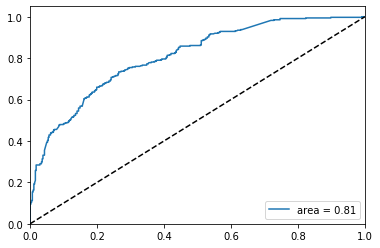

In [40]:
#проверим адекватность работы нашего "нейтрального" классификатора с помощью графика roc-auc
PredProbasForest_NC = Forest_NC_Prod.predict_proba(TestVecs_NC)[:,1]

fpr,tpr,_ = roc_curve(YTest_Neutr,PredProbasForest_NC)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label = 'area = %.2f' %roc_auc)
plt.plot([0, 1],[0, 1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.legend(loc = 'lower right')

plt.show()

"Позитивный" классификатор:

In [41]:
#провалидруем "позитивный" классификатор с помощью кросс-валидации на 5 фолдах
Forest_PC = RandomForestClassifier(n_estimators = 100,max_depth = 10)
Scores_Forest_PC = cross_val_score(Forest_PC,TrainVecs_PC,YTrain_Pos,cv = 5)
print(Scores_Forest_PC)
print(np.mean(Scores_Forest_PC))

[0.72477544 0.71909958 0.71788725 0.718403   0.72272126]
0.7205773066926742


In [42]:
#обучаем "позитивный" классификатор на всех тренировочных данных
Forest_RandSeed_PC = np.random.RandomState(41)
Forest_PC_Prod = RandomForestClassifier(n_estimators = 100,max_depth = 10,random_state = Forest_RandSeed_PC)
Forest_PC_Prod.fit(TrainVecs_PC,YTrain_Pos)
print('Test Accuracy: %.2f'%Forest_PC_Prod.score(TestVecs_PC,YTest_Pos))

Test Accuracy: 0.72


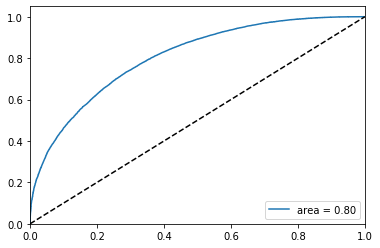

In [43]:
#проверим адекватность работы нашего "позитивного" классификатора с помощью графика roc-auc
PredProbasForest_PC = Forest_PC_Prod.predict_proba(TestVecs_PC)[:,1]

fpr,tpr,_ = roc_curve(YTest_Pos,PredProbasForest_PC)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label = 'area = %.2f' %roc_auc)
plt.plot([0, 1],[0, 1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.legend(loc = 'lower right')

plt.show()